# Controllable Text Summarization via Prompt Injection

Guiding LLMs to generate summaries of specific lengths and format (e.g., five sentences, 280 words, bullet list) poses a considerable challenge. This study seeks to experiment with prompt injection strategies aimed at directing LLMs towards fulfilling user-requested summary accurately.

Prompt injection is a technique that involves adding a prompt to the input of a language model to guide its output. The prompt can be a sentence, a paragraph, or a set of instructions that the model should follow. In this study, we will experiment with different prompt injection strategies to guide the model to generate summaries of specific lengths and formats.

We mainly focus on the following prompt injection strategies:

Reasoning-based prompts: 
-   Generate a text {10-20-30} times shorter
-   Generate a text of length e•ln^2 w.r.t. the number of words in the document

Instruction-based prompts:
-   Generate a summary of {50-75-100-125-150-175-200} words
-   Generate a 1-sentence summary
-   Generate a bullet point of 3-5-10 items summarizing the document

#### Imports and library installations:

In [ ]:
#pip install wandb

In [26]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import pandas as pd
import wandb
import math

### Dataset loading:

In [4]:
# Load dataset from file 
with open('pubmed.pkl', 'rb') as f:
    dataset = pickle.load(f)

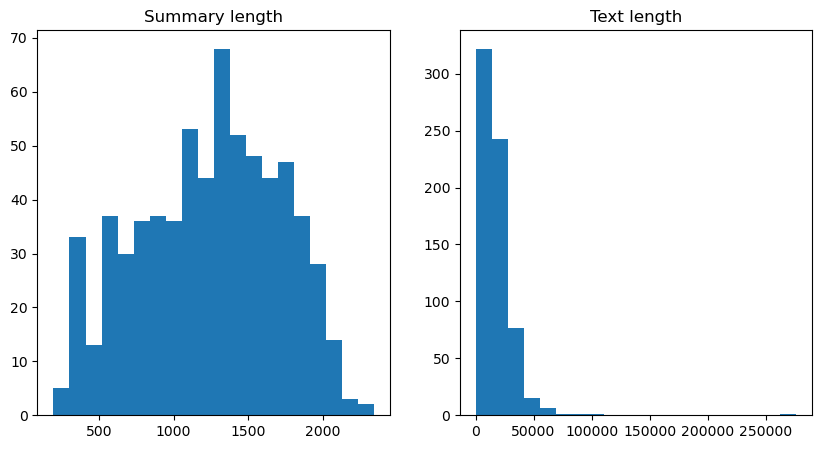

In [5]:
# Plot the length of each summary and of each text in two separate histograms as subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist([len(x) for x in dataset['summary']], bins=20)
axs[0].set_title('Summary length')
axs[1].hist([len(x) for x in dataset['document']], bins=20)
axs[1].set_title('Text length')
plt.show()

Tokenization using nltk library:

In [6]:
# Tokenize the documents and summaries
tokenized_dataframe = pd.DataFrame()
tokenized_dataframe['summary'] = dataset['summary'].apply(word_tokenize)
tokenized_dataframe['document'] = dataset['document'].apply(word_tokenize)
tokenized_dataframe['document_len'] = tokenized_dataframe['document'].apply(len)
tokenized_dataframe['original_summary'] = dataset['summary']
tokenized_dataframe['original_document'] = dataset['document']

tokenized_dataframe.head()

,summary,document,document_len,original_summary,original_document
0,"[we, determined, the, extent, and, distributio...","[survival, rates, continue, to, improve, with,...",2042,we determined the extent and distribution of c...,survival rates continue to improve with the ad...
1,"[methodsstudents, attending, five, different, ...","[for, every, living, creature, ,, elderliness,...",2535,methodsstudents attending five different types...,"for every living creature , elderliness is the..."
2,"[the, voltage, -, gated, k, channel, database,...","[voltage, -, gated, k, channels, (, vkcs, ), c...",2482,the voltage - gated k channel database ( vkcdb...,voltage - gated k channels ( vkcs ) constitute...
3,"[variations, in, quantity, and, quality, of, e...","[medicinal, plants, have, been, used, for, cen...",2561,variations in quantity and quality of essentia...,medicinal plants have been used for centuries ...
4,"[aim, ., acute, pancreatitis, is, an, inflamma...","[acute, pancreatitis, is, an, inflammatory, in...",3080,aim . acute pancreatitis is an inflammatory in...,acute pancreatitis is an inflammatory intra - ...


In [7]:
print("Number of documents: ", len(tokenized_dataframe))

Number of documents:  667


Filtering based on max context length for the model:

In [8]:
model_max_context_length = {"llama2-chat": 4096}

In [9]:
model = "llama2-chat"
max_context_length = model_max_context_length[model]

# Filter out documents that are too long
tokenized_dataframe = tokenized_dataframe[tokenized_dataframe['document_len'] <= max_context_length]

tokenized_dataframe.head()


,summary,document,document_len,original_summary,original_document
0,"[we, determined, the, extent, and, distributio...","[survival, rates, continue, to, improve, with,...",2042,we determined the extent and distribution of c...,survival rates continue to improve with the ad...
1,"[methodsstudents, attending, five, different, ...","[for, every, living, creature, ,, elderliness,...",2535,methodsstudents attending five different types...,"for every living creature , elderliness is the..."
2,"[the, voltage, -, gated, k, channel, database,...","[voltage, -, gated, k, channels, (, vkcs, ), c...",2482,the voltage - gated k channel database ( vkcdb...,voltage - gated k channels ( vkcs ) constitute...
3,"[variations, in, quantity, and, quality, of, e...","[medicinal, plants, have, been, used, for, cen...",2561,variations in quantity and quality of essentia...,medicinal plants have been used for centuries ...
4,"[aim, ., acute, pancreatitis, is, an, inflamma...","[acute, pancreatitis, is, an, inflammatory, in...",3080,aim . acute pancreatitis is an inflammatory in...,acute pancreatitis is an inflammatory intra - ...


In [10]:
print(f"Number of documents after filtering: {len(tokenized_dataframe)}")

Number of documents after filtering: 513


In [11]:
# remove from the dataframe rows in which the length of the summary is greater than the length of the document
def sanitize(df):
    df = df[df['original_summary'].apply(len) <= df['original_document'].apply(len)]
    return df 

In [12]:
tokenized_dataframe = sanitize(tokenized_dataframe)

print(f"Number of documents after sanitizing: {len(tokenized_dataframe)}")

Number of documents after sanitizing: 508


Here we define some example prompts which we use for one-shot inference:

In [13]:
prompt_example_text = "The impact of climate change on global weather patterns has become increasingly evident in recent years, with more frequent and intense storms, heatwaves, and wildfires being reported across the world. Scientists warn that without immediate and concerted efforts to reduce greenhouse gas emissions and mitigate the effects of climate change, these extreme weather events will only become more severe, posing significant risks to human societies, economies, and ecosystems."
prompt_example_summary_one_sentence = "Climate change is causing more extreme weather events worldwide, and urgent action is needed to reduce greenhouse gas emissions and mitigate its impacts to prevent further escalation of risks to society, economies, and ecosystems."
prompt_example_summary_3_bullet = "Automation and AI advancements are transforming the job market, raising worries about job displacement. Proponents highlight the potential for increased productivity, innovation, and the emergence of new job sectors. Successful adaptation requires investment in retraining programs, lifelong learning, and supportive policies for workers transitioning to new roles."
prompt_example_text_10_percent = "In recent years, advances in renewable energy technologies have significantly expanded the options for generating clean and sustainable electricity. Solar photovoltaic (PV) panels, wind turbines, and hydroelectric power plants are among the most widely adopted renewable energy sources, offering environmentally friendly alternatives to fossil fuels. These technologies harness natural resources like sunlight, wind, and water to produce electricity without emitting greenhouse gases or other harmful pollutants. As a result, renewable energy has emerged as a key solution to mitigating climate change and reducing dependence on finite fossil fuel resources. Moreover, the declining costs of renewable energy systems have made them increasingly competitive with traditional energy sources, driving widespread adoption and investment in renewable energy infrastructure worldwide."
prompt_example_summary_10_percent = "Renewable energy technologies like solar, wind, and hydro are gaining traction as clean alternatives to fossil fuels, offering environmentally friendly electricity generation without greenhouse gas emissions."

### Prompt definitions:

In [14]:
prompts_before = [
                'Generate a summary 10 times shorter for the following text: ',
                'Generate a summary 20 times shorter for the following text: ',
                'Generate a summary 30 times shorter for the following text: ',
                'Generate a summary of lenght 50 words: ',
                'Generate a summary of lenght 75 words: ',
                'Generate a summary of lenght 100 words: ',
                'Generate a summary of lenght 125 words: ',
                'Generate a summary of lenght 150 words: ',
                'Generate a summary of lenght 175 words: ',
                'Generate a summary of lenght 200 words: ',
                'Summarise this text in 1 sentence: ',
                'Summarise this text in 5 sentences: ',
                'Summarise this text in 10 sentences: ',
                'Summarise this text in 3 bullet-points: ',
                'Summarise this text in 5 bullet-points: ',
                'Summarise this text in 10 bullet-points: ',
                'Summarise this text in 1 sentence.\n Text: ',
                'Summarise this text in 5 sentences.\n Text: ',
                'Summarise this text in 10 sentences.\n Text: ',
                ]

prompts_after = [' Summary: ',
                 '',
                 ' Example summary: ',]

In [2]:
# This function is used to generate prompts for the model to generate an output on zero-shot inference
def prompt_creation_zero_shot(data, special_tokens, pb, pa, length_based=False):

    document = data['original_document']
    summary = data['original_summary']
    doc_len = data['document_len']
    if length_based:
        # Length-based prompts are used to generate summaries of different lengths = exln^2
        size = math.ceil(math.exp(1) * (math.pow(math.log(doc_len), 2)))
        print("Size: ", size)
        text = f"Generate a summary of length {size}: "
        prompt = f"{special_tokens}{text}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    prompt = f"{special_tokens}{prompts_before[pb]}{document}{prompts_after[pa]}{special_tokens}"
    return prompt

def prompt_creation_one_shot(data, special_tokens, pb, pa, ten_percent = False, one_sentence = False, three_bullet = False):
    document = data['original_document']
    summary = data['original_summary']
    if ten_percent:
        prompt = f"{special_tokens}{prompts_before[pb]}{prompt_example_text_10_percent}{prompts_after[2]}{prompt_example_summary_10_percent}{prompts_before[pb]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    if one_sentence:
        prompt = f"{special_tokens}{prompts_before[pb]}{prompt_example_text}{prompts_after[2]}{prompt_example_summary_one_sentence}{prompts_before[pb]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    if three_bullet:
        prompt = f"{special_tokens}{prompts_before[pb]}{prompt_example_text}{prompts_after[2]}{prompt_example_summary_3_bullet}{prompts_before[pb]}{document}{prompts_after[pa]}{special_tokens}"
        return prompt
    return prompt

In [15]:
prompt_creation_zero_shot(tokenized_dataframe.iloc[0], "", 0, 0, length_based=False)

"Generate a summary 10 times shorter for the following text: survival rates continue to improve with the advent of more refined treatments and better supportive care . today over 80 of children with cancer are alive for at least five years , and the majority of these are cured . as a consequence , many sufferers of childhood cancer are now living into adulthood and having families of their own . it has been estimated that about 1 in 900 adults aged 18 to 44 years is a cancer survivor . among this group , those with an inherited susceptibility to cancer will transmit their genetic fault to a proportion of their children . they are also at risk of developing a second cancer during their adult life . while the causes of the majority of childhood cancers are largely unknown , there are a number of clinical syndromes for which the evidence for an excess cancer risk in children is most persuasive . these include li - fraumeni syndrome , neurofibromatosis type i , inherited retinoblastoma mut

In [16]:
prompt_creation_one_shot(tokenized_dataframe.iloc[0], "", 0, 0, ten_percent=True, one_sentence=False, three_bullet=False)

"Generate a summary 10 times shorter for the following text: In recent years, advances in renewable energy technologies have significantly expanded the options for generating clean and sustainable electricity. Solar photovoltaic (PV) panels, wind turbines, and hydroelectric power plants are among the most widely adopted renewable energy sources, offering environmentally friendly alternatives to fossil fuels. These technologies harness natural resources like sunlight, wind, and water to produce electricity without emitting greenhouse gases or other harmful pollutants. As a result, renewable energy has emerged as a key solution to mitigating climate change and reducing dependence on finite fossil fuel resources. Moreover, the declining costs of renewable energy systems have made them increasingly competitive with traditional energy sources, driving widespread adoption and investment in renewable energy infrastructure worldwide. Example summary: Renewable energy technologies like solar, w

### Connection to WandB:

In [2]:
wandb.login(key='YOUR_API_KEY')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cipdev16 (deep-mining-project). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Ciprian\.netrc


True

In [4]:
run = wandb.init(
    # Set the project where this run will be logged
    project="TEST"
)

### Metric definitions:

We use simple criteria to assess the correctness of the generated summaries. Specifically, we use NLTK word_tokenize to check the number of predicted words and compare them with the instruction given.

In [27]:
def percent_check(input, output, percent):
    tokenized_input = word_tokenize(input)
    tokenized_output = word_tokenize(output)
    if len(output) <= len(input) * percent:
        return True
    return False

def length_check(output, length):
    tokenized_input = word_tokenize(input)
    tokenized_output = word_tokenize(output)
    if len(tokenized_output) <= length:
        return True
    return False

def sentence_check(output, sentence_length):
    tokenized_output = sent_tokenize(output)
    if len(tokenized_output) <= sentence_length:
        return True
    return False

Furthermore, we should also test the quality of the generated summaries. As we cannot rely on a target summary, we selected BARTScore to evaluate the factualness and semantic similarity of the predicted summary against the source document.

In [28]:
from bart_score import BARTScorer

scorer = BARTScorer()
scorer.load(path="bart_score.pth")

def calculate_bart_score(hypotheses, references):
    score = scorer.score(references, hypotheses)
    return score


d:\Anaconda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


d:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ciprian\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [29]:
calculate_bart_score(["The quick brown fox jumps over the lazy dog"], ["The quick brown fox jumps over the lazy dog"])

[-1.2076964378356934]